# Homework 02 - How do Taxis move in NYC?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, time
import numpy as np
from scipy.stats import chisquare,chi2_contingency
from scipy import stats
import folium as folium
import json as json

#This function only returns the date of the trip

def date(row): 
    return row.date()

#This function returns the time slot of a trip

def timeSlot(row):
    if time(0,1,0) <= row.time() <= time(6,0,0):
        return 1
    elif time(6,1,0) <= row.time() <= time(12,0,0):
        return 2
    elif time(12,1,0) <= row.time() <= time(18,0,0):
        return 3
    else:
        return 4
    
# This function returns the trip's duration in minutes

def minutes(row): 
    return row//60

# This function returns duration slot of a trip 

def duration_trip (row): 
    if 0 <= row <= 15:
        return '[0-15]'
    elif 16 <= row <= 30:
        return '[16-30]'
    elif 31 <= row <= 45 :
        return '[31-45]'
    elif 46 <= row <= 60:
        return '[46-60]'
    else: 
        return '[60+]'    
    
n = 1
month = ['January', 'February', 'March', 'April', 'May', 'June']
avg_month_ny = {}
avg_month_borough = {}
time_slot_month_ny = {}
time_slot_month_borough = {}
duration_trip_ny = {}
duration_trip_borough = {}
payment_ny_global = {}
payment_borough_global = {}
payment_borough_percentage_global = {}
df_global = pd.DataFrame(columns=['duration', 'trip_distance'])
parse_dates = ['tpep_pickup_datetime', 'tpep_dropoff_datetime']

# We import the csv file containing the data of Taxi zone , in order to have a dataset with all the informations. We import only
# the columns that interest us for our analysis.

df_zone = pd.read_csv('taxi_zone_lookup.csv', usecols=[0,1], encoding = 'ISO-8859-1')

# Research questions

## Exploratory Data Analysis

### [RQ1] _In what period of the year Taxis are used more?_ 

The final goal of this request is to determinate in what period of the year Taxis are used more, first in NYC and then in each borough of NYC. 

Before accomplishing the task we need to pass through the following steps:

1. Obtain the data for the Taxis in NYC, starting from January 2018
2. Keep only the trips belonging to the month in question (ie. January 2018)
3. Merge between the data for the Taxis and the data for the taxi zone of NYC
4. Compute the average daily number of trips, first in NYC and then in each borough of NYC
5. Repeat the previous steps for each month until June 2018

In [2]:
while(n<7):
    csv = "yellow_tripdata_2018-0"+str(n)+".csv"

    # Step 1: Obtain the data for the Taxis in NYC, starting from January 2018
    
    # The first thing we do is to import the csv file containing the data of Taxis in NYC, in order to have a dataset with all
    # the informations. We import only the columns that interest us for our analysis. We parse the 'tpep_pickup_datetime' and
    # 'tpep_pickup_datetime' columns as dates.

    df_taxi= pd.read_csv(csv, usecols = [1,2,3,4,7,8,9,16], parse_dates = parse_dates, encoding = 'ISO-8859-1')
    
    # Step 2: Keep only the trips belonging to the month in question (ie. January 2018)
    
    # We clen the dataset. We drop the rows containig wrong values, as: different year from 2018, different month for the 
    # pickup datetime and dropoff datetime columns. We consider the trips at midnight as belonging to the day of pick up.

    df_taxi = df_taxi[df_taxi['tpep_pickup_datetime'].dt.year == 2018]
    df_taxi = df_taxi[df_taxi['tpep_pickup_datetime'].dt.month == n]
    df_taxi = df_taxi[df_taxi['tpep_dropoff_datetime'].dt.year == 2018]
    df_taxi = df_taxi[df_taxi['tpep_dropoff_datetime'].dt.month <= n+1]
    
    # Step 3: Merge between the data for the Taxis and the data for the taxi zone of NYC
    
    # We perform a left join between the taxi dataset and the taxi zone dataset on 'PULocationID' and 'LocationId' columns, respectively 

    df_join = pd.merge(df_taxi,df_zone, how = 'left', left_on=['PULocationID'], right_on=['LocationID'])
    
    del df_taxi
    
    # Step 4: Compute the average daily number of trips, first in NYC and then in each borough of NYC
    
    # The first thing to do is to create a new column in our dataset where we only put the date of the pickup trip. Then we execute
    # a groupby operation on date and borough columns.
    
    df_join['date'] = df_join['tpep_pickup_datetime'].apply(date)
    date_borough = df_join.groupby(['date','Borough']).date.count()

    rows, col = df_join.shape
    
    del df_join
    
    # Now we execute the avarage daily number of trips in NYC : number of rows of our dataset (total trips) / number of days in that month
   
    avg_race_ny = round(rows//len(date_borough.keys().levels[0]),2)
    
    # We save our results in a dictionary (called avg_month_ny) containing all the avarage daily number of trips for each month in analysis. 
    
    avg_month_ny[month[n-1]] = avg_race_ny

    date_borough_dict = date_borough.to_dict()
    
    # We create a new dictionary (called races_borough) that has as keys the boroughs and as values the total races for the month in analysis.
   
    races_borough = {}
    for i in date_borough_dict:
        if i[1] not in races_borough:
            races_borough[i[1]] = date_borough_dict[i]
        else: 
            races_borough[i[1]] += date_borough_dict[i]
            
    # We create a new dictionary (called daily_races) that has as keys the boroughs and as values the average daily number of trips for each boroughs.
   
    daily_races = {}
    for i in races_borough:
        daily_races[i] = races_borough[i]//len(date_borough.keys().levels[0])
    
    # We save our results in a dictionary (called avg_month_borough) containing all the avarage daily number of trips for each month and borough.
    
    avg_month_borough[month[n-1]] = daily_races
    
    # Step 5: Repeat the previous steps for each month until June 2018
    
    n += 1
    

We use the matplotlib.pyplot library to create a histogram that shows the avarage number of trips recorded each month in NYC

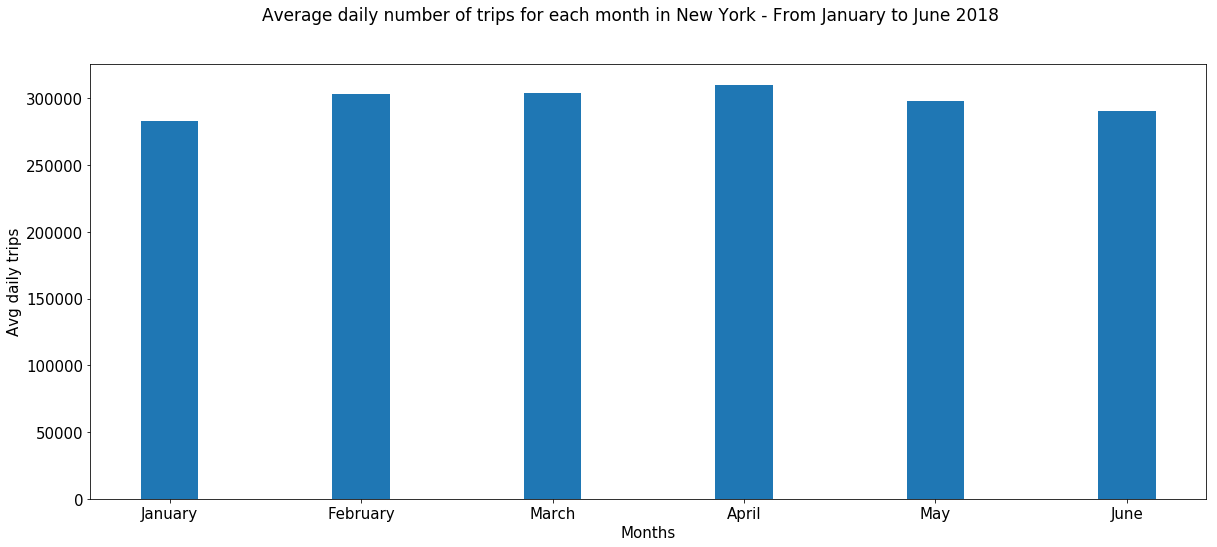

In [3]:
fig, ax = plt.subplots(figsize=(20,8))
fig.suptitle('Average daily number of trips for each month in New York - From January to June 2018',fontsize = 17)
plt.bar(range(len(avg_month_ny)),list(avg_month_ny.values()), align = 'center',width = 0.3)
plt.xticks(range(len(avg_month_ny)),list(avg_month_ny.keys()))
ax.tick_params(labelsize=15)
plt.xlabel('Months', fontsize=15)
plt.ylabel('Avg daily trips', fontsize=15)
plt.show()

In [4]:
pd.Series(avg_month_ny)

January     282565
February    303263
March       304162
April       310167
May         297540
June        290443
dtype: int64

This histogram has on the x axis the months of the period in analysis and on the y axis the avarage daily number of trips in NYC. We can observe that the period of the year where taxis are used more is between February and April with a 
peak in April with about 310167 trips in mean in one day. 

In [5]:
# We calculate the avarage daily number of trips for each borough for the whole period taken in analysis. For each borough 
# we sum the avarage daily number of trips of every month and then we divide each sum to the number of the months taken into 
# consideration in our analysis (number of the months taken into consideration in our analysis = 6)

result = {}
for i in avg_month_borough: 
    for j in avg_month_borough[i]: 
        if j not in result: 
            result[j] = avg_month_borough[i][j]
        else: 
            result[j] += avg_month_borough[i][j]

for i in result: 
    result[i] = result[i]//6

We use the matplotlib.pyplot library to create a histogram that shows the avarage number of trips recorded in each borough of NYC in the whole period taken in analisys. 

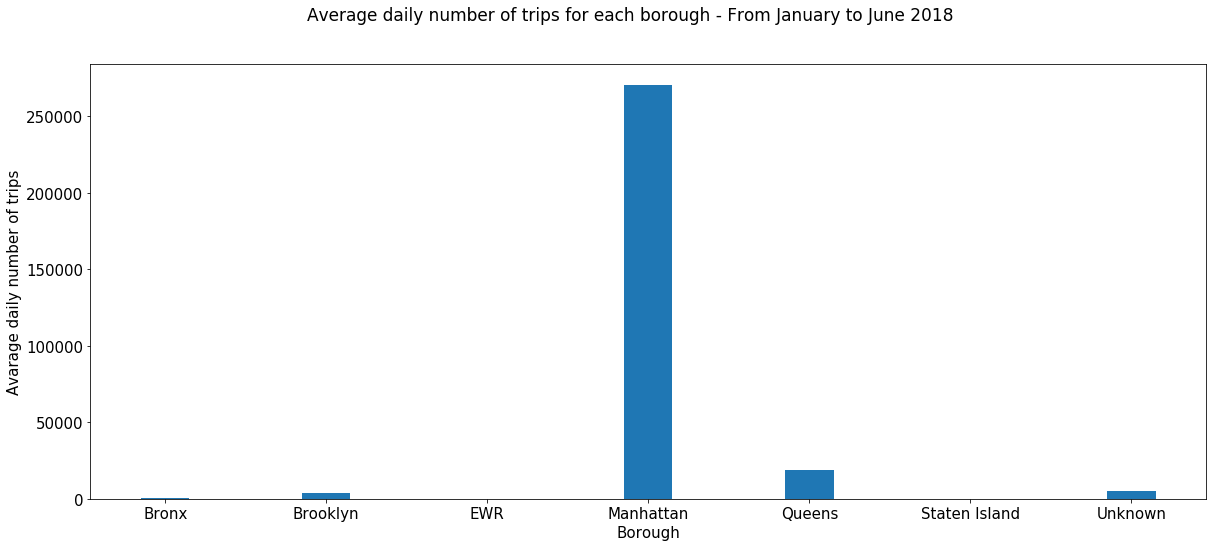

In [6]:
fig, ax = plt.subplots(figsize=(20,8))
fig.suptitle('Average daily number of trips for each borough - From January to June 2018',fontsize = 17)
plt.bar(range(len(result)),list(result.values()), align = 'center',width = 0.3)
plt.xticks(range(len(result)),list(result.keys()))
ax.tick_params(labelsize=15)
plt.xlabel('Borough', fontsize=15)
plt.ylabel('Avarage daily number of trips', fontsize=15)
plt.show()

This histogram has on the x axis the borough of NYC and on the y axis the avarage daily number of trips in each borough. We can observe that the borough of NYC where taxis are used more is Manhattan. As we can observe the difference among Manhattan and the others boroughs is very marked we suppose that this high value for Manhattan is due to the fact that is the core of the city of NYC, in addition to being a tourist area it is a crucial area for office workers. 

In [7]:
pd.DataFrame(avg_month_borough)

,January,February,March,April,May,June
Bronx,238,234,333,347,350,340
Brooklyn,3233,3396,3965,3968,3961,4098
EWR,18,17,21,23,24,22
Manhattan,256948,277401,276368,280945,269345,262610
Queens,16996,17303,18218,19876,19703,19157
Staten Island,4,3,4,4,4,5
Unknown,5125,4907,5250,5001,4150,4208


### [RQ2] _What are the time slots with more passengers?_ 

The final goal of this request is to determinate which are the time slots when Taxis drive the highest number of passengers overall NYC and then for each borough of NYC. 

We decide to concentrate our analysis only on pickup_datetime column. 

We decide to divide our time slots in 4 slots, which are: 

1) **First slot** : [00:01 - 06:00] - Night

2) **Second slot**: [06:01 - 12:00] - Morning

3) **Third slot**: [12:01 - 18:00] - Afternoon

4) **Fourth slot**: [18:01 - 00:00] - Evening 

Before accomplishing the task we need to pass through the following steps:

1. Obtain the data for the Taxis in NYC, starting from January 2018
2. Keep only the trips belonging to the month in question (ie. January 2018)
3. Merge between the data for the Taxis and the data for the taxi zone of NYC
4. Compute the number of passengers for each time slots, first in NYC and then in each borough
5. Repeat the previous steps for each month until June 2018

In [10]:
n = 1
while(n<7):
    csv = "yellow_tripdata_2018-0"+str(n)+".csv"
    
    # Step 1: Obtain the data for the Taxis in NYC, starting from January 2018
    
    # The first thing we do is to import the csv file containing the data of Taxis in NYC, in order to have a dataset with all
    # the informations. We import only the columns that interest us for our analysis. We parse the 'tpep_pickup_datetime' and
    # 'tpep_pickup_datetime' columns as dates.

    df_taxi = pd.read_csv(csv, usecols = [1,2,3,4,7,8,9,16], parse_dates = parse_dates, encoding = 'ISO-8859-1') 
    
    # Step 2: Keep only the trips belonging to the month in question (ie. January 2018)
    
    # We clen the dataset. We drop the rows containig wrong values, as: different year from 2018, different month for the 
    # pickup datetime and dropoff datetime columns, trips that record 0 passengers. 
    # We consider the trips at midnight as belonging to the day of pick up.

    df_taxi = df_taxi[df_taxi['tpep_pickup_datetime'].dt.year == 2018]
    df_taxi = df_taxi[df_taxi['tpep_pickup_datetime'].dt.month == n]
    df_taxi = df_taxi[df_taxi['tpep_dropoff_datetime'].dt.year == 2018]
    df_taxi = df_taxi[df_taxi['tpep_dropoff_datetime'].dt.month <= n+1]
    df_taxi = df_taxi[df_taxi['passenger_count'] != 0] 
    
    # Step 3: Merge between the data for the Taxis and the data for the taxi zone of NYC
    
    # We perform a left join between the taxi dataset and the taxi zone dataset on 'PULocationID' and 'LocationId' columns, respectively 
    
    df_join = pd.merge(df_taxi,df_zone, how = 'left', left_on=['PULocationID'], right_on=['LocationID'])
    
    del df_taxi
    
    # Step 4: compute the number of passengers for each time slots, first in NYC and then in each borough

    # The first thing to do is to create a new column in our dataset where we only put the time slot of the pickup trip.
    
    df_join['time_slot'] = df_join['tpep_pickup_datetime'].apply(timeSlot)
    
    # We only consider the columns: passenger_count, time_slot and borough
    
    df_passenger = df_join[['passenger_count','time_slot','Borough']]
    
    del df_join
    
    # Then we execute a groupby operation on time slot column and sum the number of passengers of each time slot
    
    passenger_count_ny = df_passenger.groupby(['time_slot']).passenger_count.sum()
    
    # We save our results in a dictionary (called time_slot_month_ny) containing the number of passenger for each month and time slot
    
    time_slot_month_ny[month[n-1]] = passenger_count_ny.to_dict()
    
    # We execute a groupby operation on borough and time slot columns and sum the number of passengers of each time slot for each borough

    passenger_count_borough = df_passenger.groupby(['Borough','time_slot']).passenger_count.sum()
    
    passenger_count_borough_dict = passenger_count_borough.to_dict()
    
    # We create a new dictionary (called total_passenger_borough) that has as keys the boroughs and as values the total number
    # of passengers for the month in analysis.
    
    total_passenger_borough = {}
    for i in passenger_count_borough_dict: 
        if i[0] not in total_passenger_borough:
            total_passenger_borough[i[0]] = passenger_count_borough_dict[i]
        else: 
             total_passenger_borough[i[0]] += passenger_count_borough_dict[i]
                
    # We calculate the percentage of passengers in each borough and time slot. We divide the number of passengers of each borough
    # and time slot to the total number of passengers for each borough 
    
    d_percentage = {}
    for i in passenger_count_borough_dict: 
        d_percentage[i] = round((passenger_count_borough_dict[i] / total_passenger_borough[i[0]])*100,1)
    
    # We save our results in a dictionary (called time_slot_month_borough) containing the total number of passengers for each month
    # borough and time slot. 
    
    time_slot_month_borough[month[n-1]] = d_percentage
    
    # Step 5: Repeat the previous steps for each month until June 2018
    
    n += 1

In [11]:
# We calculate the avarage total number of passengers for NYC in the whole period taken in analysis.
# We sum the number of passengers for every month and then we divide each sum to the number of the months taken into 
# consideration in our analysis (number of the months taken into consideration in our analysis = 6)

result = {}
for i in time_slot_month_ny: 
    for j in time_slot_month_ny[i]: 
        if j not in result: 
            result[j] = time_slot_month_ny[i][j]
        else: 
            result[j] += time_slot_month_ny[i][j]

for i in result: 
    result[i] = result[i]//6

We create an histogram that shows the number of passengers for each time slots in NYC for the whole period in analysis.

Text(0.5,1,'Number of passengers for each time slots, New York - From January to June 2018')

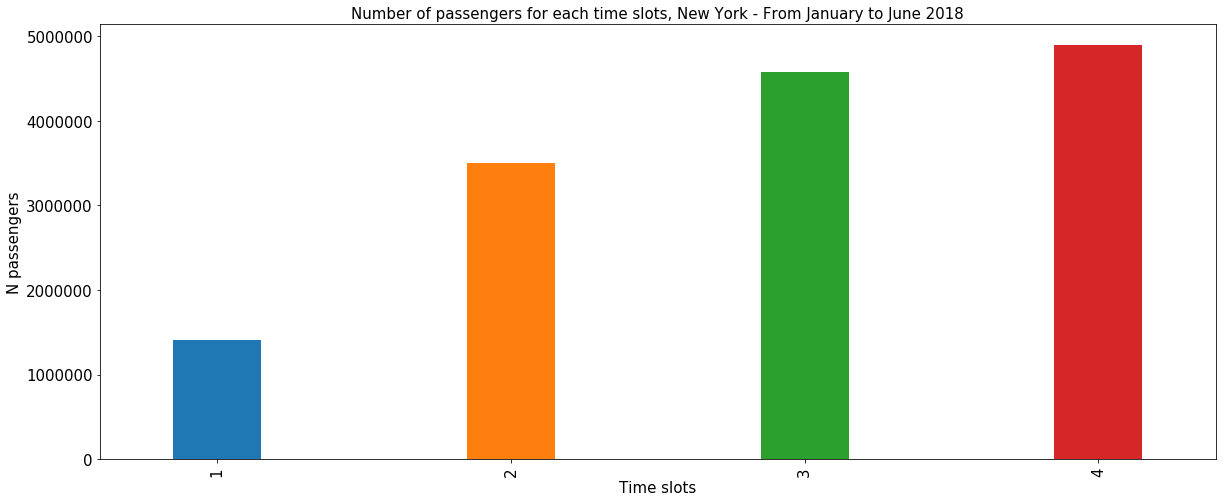

In [12]:
ax = pd.Series(result).plot(kind='bar',figsize=(20,8),legend=False, fontsize=15, width = 0.3)
ax.set_xlabel("Time slots",fontsize=15)
ax.set_ylabel("N passengers",fontsize=15)
ax.set_title('Number of passengers for each time slots, New York - From January to June 2018', fontsize=15)

This histogram has on the x axis the time slots and on the y axis the number of passengers in NYC. We can observe that the time slot with the highest number of passengers is the evening time slot [18:01 - 00:00] with about 4893083 passengers. 

In [13]:
pd.Series(result)

1    1412454
2    3502764
3    4569445
4    4893083
dtype: int64

In [14]:
# We calculate the avarage total number of passangers for each borough and time slot in the whole period taken in analysis. 
# For each borough and time slot we sum the number of passengers of every month and then we divide each sum to the number of the 
# months taken into consideration in our analysis (number of the months taken into consideration in our analysis = 6)

result = {}
for i in time_slot_month_borough: 
    for j in time_slot_month_borough[i]: 
        if j not in result: 
            result[j] = time_slot_month_borough[i][j]
        else: 
            result[j] += time_slot_month_borough[i][j]

for i in result: 
    result[i] = result[i]//6

We create an histogram that shows for each borough the number of passengers for each time slot in percentage in NYC for the whole period in analysis.

Text(0.5,1,'Percentage of passengers for each borough and time slots - From January to June 2018')

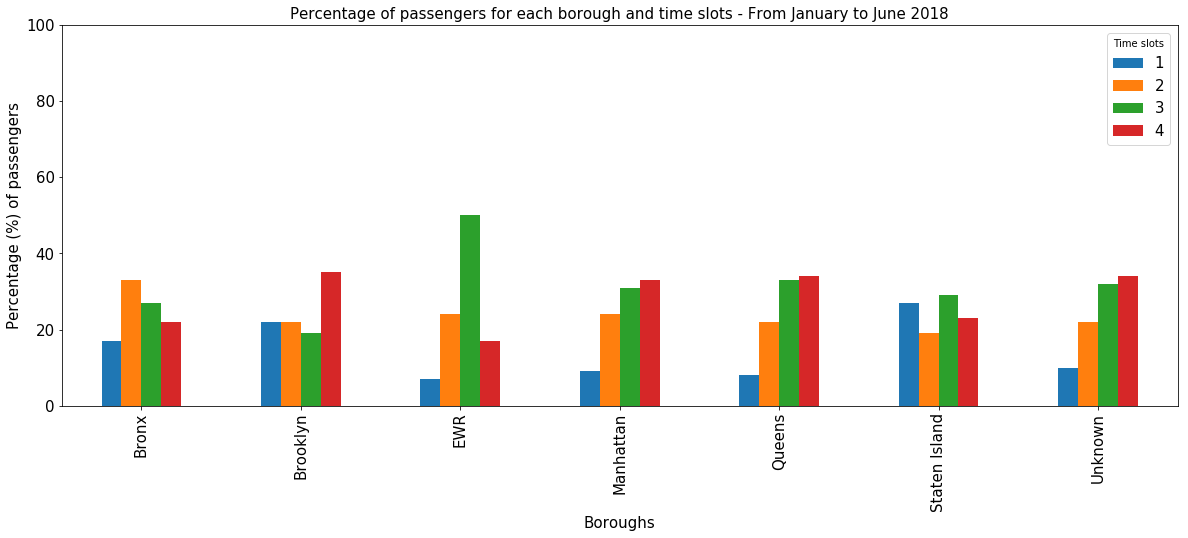

In [15]:
ax = pd.Series(result).unstack().plot.bar(figsize=(20,7),fontsize = 15, ylim=[0,100])
ax.set_xlabel("Boroughs",fontsize=15)
ax.set_ylabel("Percentage (%) of passengers",fontsize=15)
ax.legend(fontsize=15, title = 'Time slots')
ax.set_title('Percentage of passengers for each borough and time slots - From January to June 2018', fontsize=15)

This histogram has on the x axis the boroughs of NYC and on the y axis the percentage of passengers. We can observe that Queens and Manhattan have a similar distribution of passengers in each time slot with the highest number of passengers in the evening slot, about 33% and 34% respectively. In the Bronx the highest number of passengers is in the morning slot (27%). 
In the Brooklyn the highest number of passengers is in the evening slot (35%). In the EWR the highest number of passengers is in the afternoon slot (50%). In the Staten Island the highest number of passengers is in the afternoon slot (29%). 

In [51]:
pd.Series(result)

Bronx          1    17.0
               2    33.0
               3    27.0
               4    22.0
Brooklyn       1    22.0
               2    22.0
               3    19.0
               4    35.0
EWR            1     7.0
               2    24.0
               3    50.0
               4    17.0
Manhattan      1     9.0
               2    24.0
               3    31.0
               4    33.0
Queens         1     8.0
               2    22.0
               3    33.0
               4    34.0
Staten Island  1    27.0
               2    19.0
               3    29.0
               4    23.0
Unknown        1    10.0
               2    22.0
               3    32.0
               4    34.0
dtype: float64

### [RQ3]  _Do the all trips last the same?_

The final goal of this request is to determinate the distribution of trips's duration, first overall NYC and then for each borough of NYC. 

When we deal with boroughs we decided to divide the trip's duration in 5 slots: 

- [0-15] minutes

- [16 -30] minutes

- [31 - 45] minutes

- [60+] minutes

Before accomplishing the task we need to pass through the following steps:

1. Obtain the data for the Taxis in NYC, starting from January 2018
2. Keep only the trips belonging to the month in question (ie. January 2018)
3. Merge between the data for the Taxis and the data for the taxi zone of NYC
4. Compute the distribution of trip's duration, first in NYC and then in each borough
5. Repeat the previous steps for each month until June 2018

In [16]:
n = 1
while(n<7):
    csv = "yellow_tripdata_2018-0"+str(n)+".csv"
    
    # Step 1: Obtain the data for the Taxis in NYC, starting from January 2018
    
    # The first thing we do is to import the csv file containing the data of Taxis in NYC, in order to have a dataset with all
    # the informations. We import only the columns that interest us for our analysis. We parse the 'tpep_pickup_datetime' and
    # 'tpep_pickup_datetime' columns as dates.
    
    df_taxi= pd.read_csv(csv, usecols = [1,2,3,4,7,8,9,16], parse_dates = parse_dates, encoding = 'ISO-8859-1') 
    
    # Step 2: Keep only the trips belonging to the month in question (ie. January 2018)
    
    # We clen the dataset. We drop the rows containig wrong values, as: different year from 2018, different month for the 
    # pickup datetime and dropoff datetime columns, same value in pickup_datetime and dropoff_datetime columns. 
    # We consider the trips at midnight as belonging to the day of pick up.
    
    df_taxi = df_taxi[df_taxi['tpep_pickup_datetime'].dt.year == 2018]
    df_taxi = df_taxi[df_taxi['tpep_pickup_datetime'].dt.month == n]
    df_taxi = df_taxi[df_taxi['tpep_dropoff_datetime'].dt.year == 2018]
    df_taxi = df_taxi[df_taxi['tpep_dropoff_datetime'].dt.month <= n+1]
    df_taxi = df_taxi[df_taxi['tpep_dropoff_datetime'] != df_taxi['tpep_pickup_datetime']]
    
    # Step 3: Merge between the data for the Taxis and the data for the taxi zone of NYC
    
    # We perform a left join between the taxi dataset and the taxi zone dataset on 'PULocationID' and 'LocationId' columns, respectively 
    
    df_join = pd.merge(df_taxi,df_zone, how = 'left', left_on=['PULocationID'], right_on=['LocationID'])
    
    del df_taxi
    
    # Step 4: compute the distribution of trip's duration, first in NYC and then in each borough
    
    # The first thing to do is to create a new column in our dataset where we put the difference between dropoff datetime and 
    # pickup datetime that is the trip's duration. We drop the rows that have duration more than 1 day and negative duration.
    # We decide to keep only the trips with maximum duration of 4 hours. 
    
    df_join['duration'] = df_join['tpep_dropoff_datetime']-df_join['tpep_pickup_datetime']
    df_join = df_join[df_join['duration'].dt.days == 0]
    df_join = df_join[df_join['duration'].dt.seconds <= (3600*4)]
    
    # First we considered the trip's duration in seconds
    
    d_minutes = df_join['duration'].dt.seconds
    
    d_minutes = pd.DataFrame(d_minutes)
    
    # Then we commute the trip's duration from seconds to minutes
    
    d_minutes = d_minutes['duration'].apply(minutes)
    
    # We execute a groupby operation on duration column and count the number of trips there are for each duration
    
    d_minutes_ny = d_minutes.groupby(d_minutes).count()
    
    # We save our results in a dictionary (called duration_trip_ny) containing the number of trips for each month and duration 
    
    duration_trip_ny[month[n-1]] = d_minutes_ny.to_dict()

    df_borough = pd.DataFrame(df_join['Borough'])

    del df_join
    
    # We repeat our analysis for each borough 
    
    df_borough['duration'] = d_minutes
    
    # We execute a groupby operation on borough and duration columns and then we count the number of trips there are 
    # for each duration in every borough 
    
    df_borough = df_borough.groupby(['Borough','duration']).duration.count()

    df_borough = pd.DataFrame(pd.Series(df_borough.to_dict()))
    df_borough.columns = ['n_races']

    df_borough = df_borough.reset_index()
                                      
    df_borough.columns = ['borough', 'minutes', 'n_races']

    # We create a new column (called duration_trip) where we put the duration slot of each trip
    
    df_borough['duration_trip'] = df_borough['minutes'].apply(duration_trip)

    # We execute a groupby operation on borough and duration trip columns and then we compute the number of trip in each duration 
    # slot for each borough
    
    df_borough = df_borough.groupby(['borough', 'duration_trip']).n_races.sum()
                                      
    temp = df_borough.to_dict()
    
    # We calculate the percentage of trips in each borough and duration slot. We divide the number of trips of each borough
    # and duration slot to the total number of trips for each borough 
    
    total_races = {}
    for i in temp: 
        if i[0] not in total_races: 
            total_races[i[0]] = temp[i]
        else: 
            total_races[i[0]] += temp[i]

    d_percentage = {}
    for i in temp: 
        d_percentage[i] = round((temp[i] / total_races[i[0]])*100,1)
        
    # We save our results in a dictionary (called duration_trip_borough) containing the total number of trips in each borough
    # and duration slot for each month
    
    duration_trip_borough[month[n-1]] =  d_percentage   
    
    # Step 5: Repeat the previous steps for each month until June 2018
    
    n += 1

In [17]:
# We calculate the avarage number of trips for each month and duration in NYC in the whole period taken in analysis.
# We sum the number of trips for each duration slot for every month and then we divide each sum to the number of the months taken into 
# consideration in our analysis (number of the months taken into consideration in our analysis = 6)

result = {}
for i in duration_trip_ny: 
    for j in duration_trip_ny[i]: 
        if j not in result: 
            result[j] = duration_trip_ny[i][j]
        else: 
            result[j] += duration_trip_ny[i][j]
            
for i in result: 
    result[i] = result[i]//6

result = pd.Series(result)

We create a function that shows the distribution of trip's duration (in minutes) in NYC for the whole period in analysis.

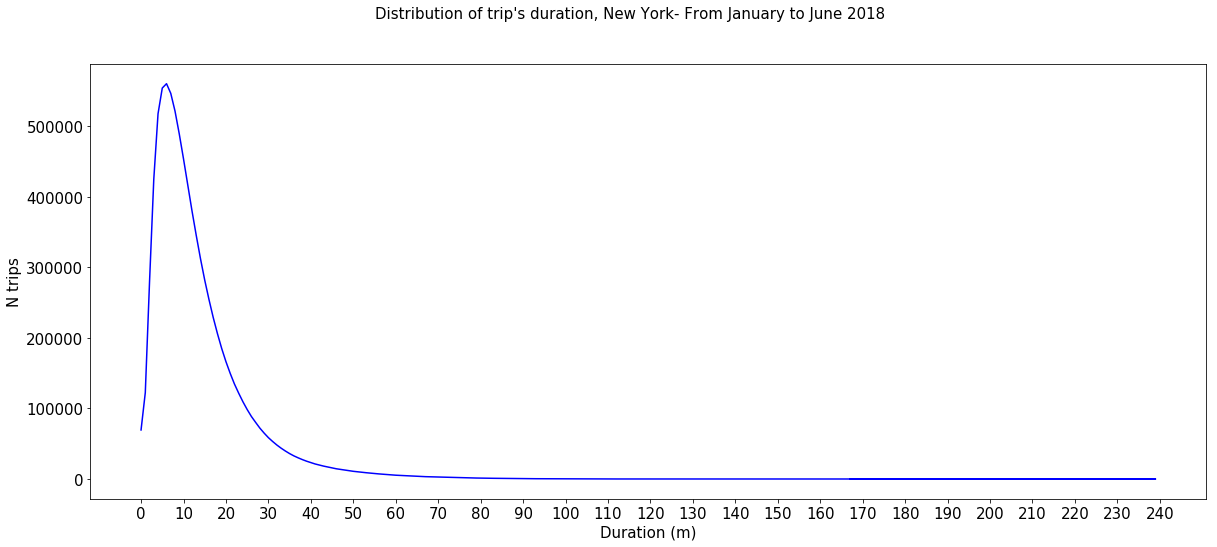

In [18]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(result, color = 'blue')
fig.suptitle("Distribution of trip's duration, New York- From January to June 2018",fontsize = 15)
ax.tick_params(labelsize=15)
plt.xlabel('Duration (m)', fontsize=15)
plt.ylabel('N trips', fontsize=15)
plt.xticks(np.arange(0, 241, step=10))
plt.show()

The plot has on the x axis the trip's duration (in minutes) and on the y axis the number of trips. From the performance of the function we can observe that in NYC the greatest number of trips have a duration about 6 minutes.  
In fact it is clearly visible that the function is growing between 0 and 6 minutes, and the fuction is decreasing between 6 and  about 60 minutes and then it is constant. 

In [19]:
# We calculate the avarage number of trips for each month and duration in each borough in the whole period taken in analysis.
# We sum the number of trips for each borough and duration slot for every month and then we divide each sum to the number of the months taken into 
# consideration in our analysis (number of the months taken into consideration in our analysis = 6)

result = {}
for i in duration_trip_borough: 
    for j in duration_trip_borough[i]: 
        if j not in result: 
            result[j] = duration_trip_borough[i][j]
        else: 
            result[j] += duration_trip_borough[i][j]

for i in result: 
    result[i] = result[i]//6

We create an histogram that shows the number of trips, in percentage, for each borough and duration slot in NYC for the whole period in analysis.

Text(0.5,1,'Number of trips, in percentage, for each borough and duration slot- From January to June 2018')

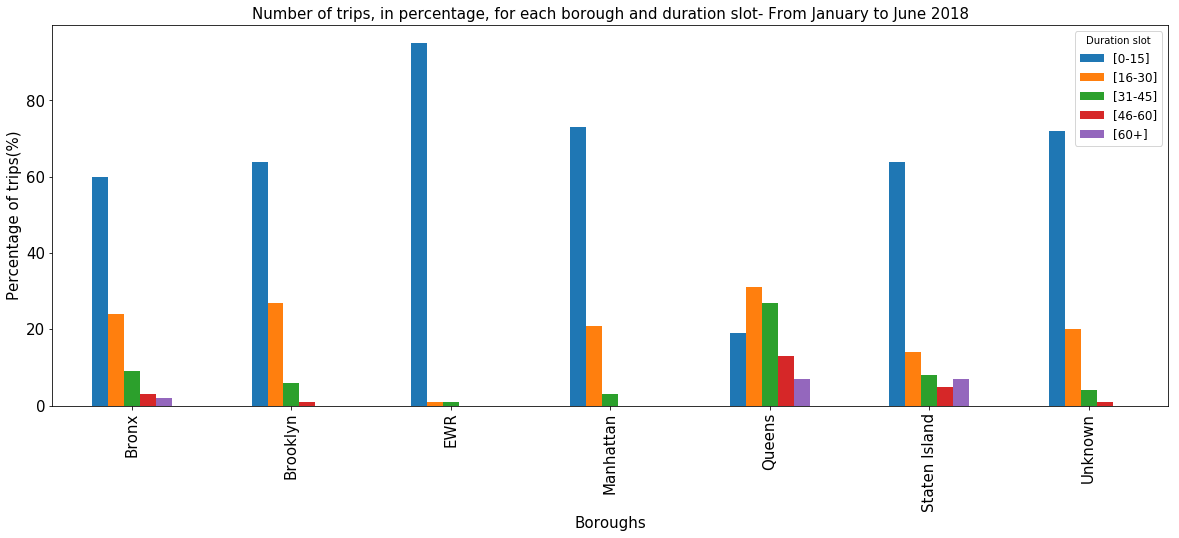

In [20]:
result = pd.Series(result)
ax = result.unstack().plot.bar(figsize =(20,7), fontsize = 15)
ax.set_xlabel("Boroughs",fontsize=15)
ax.set_ylabel("Percentage of trips(%)",fontsize=15)
ax.legend(fontsize=12, title = 'Duration slot')
ax.set_title("Number of trips, in percentage, for each borough and duration slot- From January to June 2018", fontsize=15)

This histogram has on the x axis the boroughs of NYC and on the y axis the percentage of trips. We can observe that for all boroughs, except for Queens, the most of the trips have duration less than 15 minutes (60% - 74%). Queens has a particular structure of trip's duration distribution compared to the others boroughs. In fact here the most of trips have duration between 16 and 30 minutues. The trips that have a duration more than 40 minutes are present to a greater extent in Queens and Staten Island. In EWR the trips that have a duration less than  15 minutes respresent almost all the trips (95%).

In [21]:
result

Bronx          [0-15]     60.0
               [16-30]    24.0
               [31-45]     9.0
               [46-60]     3.0
               [60+]       2.0
Brooklyn       [0-15]     64.0
               [16-30]    27.0
               [31-45]     6.0
               [46-60]     1.0
               [60+]       0.0
EWR            [0-15]     95.0
               [16-30]     1.0
               [31-45]     1.0
               [46-60]     0.0
               [60+]       0.0
Manhattan      [0-15]     73.0
               [16-30]    21.0
               [31-45]     3.0
               [46-60]     0.0
               [60+]       0.0
Queens         [0-15]     19.0
               [16-30]    31.0
               [31-45]    27.0
               [46-60]    13.0
               [60+]       7.0
Staten Island  [0-15]     64.0
               [16-30]    14.0
               [31-45]     8.0
               [46-60]     5.0
               [60+]       7.0
Unknown        [0-15]     72.0
               [16-30]    20.0
        

### [RQ4]  _What is the most common way of payments?_

The final goal of this request is to determinate which way of payment is most used, first overall NYC and then for each borough of NYC and whether the method of payment is correlated to the borough. 

The payment type are the following: 

1) Credit card

2) Cash

3) No charge

4) Dispute

5) Unknown 

6) Voided trip

Before accomplishing the task we need to pass through the following steps:

1. Obtain the data for the Taxis in NYC, starting from January 2018
2. Keep only the trips belonging to the month in question (ie. January 2018)
3. Merge between the data for the Taxis and the data for the taxi zone of NYC
4. Compute the number of payments for each way of payments, first in NYC and then in each borough
5. Repeat the previous steps for each month until June 2018
6. Run Chi-squared test to see whether the method of payment is correlated to the borough

In [22]:
n = 1
while(n<7):
    csv = 'yellow_tripdata_2018-0'+str(n)+'.csv'
    
    # Step 1: Obtain the data for the Taxis in NYC, starting from January 2018
    
    # The first thing we do is to import the csv file containing the data of Taxis in NYC, in order to have a dataset with all
    # the informations. We import only the columns that interest us for our analysis. We parse the 'tpep_pickup_datetime' and
    # 'tpep_pickup_datetime' columns as dates.

    df_taxi = pd.read_csv(csv, usecols = [1,2,3,4,7,8,9,16], parse_dates = parse_dates, encoding = 'ISO-8859-1')
    
    # Step 2: Keep only the trips belonging to the month in question (ie. January 2018)
    
    # We clen the dataset. We drop the rows containig wrong values, as: different year from 2018, different month for the 
    # pickup datetime and dropoff datetime columns, payment type less than 1 and more than 6, N/A values in payment type column. 
    # We consider the trips at midnight as belonging to the day of pick up.

    df_taxi = df_taxi[df_taxi['tpep_pickup_datetime'].dt.year == 2018]
    df_taxi = df_taxi[df_taxi['tpep_pickup_datetime'].dt.month == n]
    df_taxi = df_taxi[df_taxi['tpep_dropoff_datetime'].dt.year == 2018]
    df_taxi = df_taxi[df_taxi['tpep_dropoff_datetime'].dt.month <= n+1]
    df_taxi = df_taxi[df_taxi['payment_type'] >= 1]
    df_taxi = df_taxi[df_taxi['payment_type'] <= 6]
    df_taxi = df_taxi.dropna(subset=['payment_type'])
    
    # Step 3: Merge between the data for the Taxis and the data for the taxi zone of NYC
    
    # We perform a left join between the taxi dataset and the taxi zone dataset on 'PULocationID' and 'LocationId' columns, respectively 

    df_join = pd.merge(df_taxi,df_zone, how = 'left', left_on=['PULocationID'], right_on=['LocationID'])
    
    del df_taxi
    
    # Step 4: Compute the number of payments for each way of payments, first in NYC and then in each borough
    
    # We only consider the columns borough and payment type 
    
    df_payment = df_join[['Borough', 'payment_type']]
    
    # We execute a groupby operation on payment type and then we count the number of payment with the same type in NYC 
    
    payment_ny = df_payment.groupby('payment_type').count()
    payment_ny.columns = ['n_payments']
    
    # We save our result in a dictionary (called payment_ny_global) containing the number of payments for each month and payment type
    
    payment_ny_global[month[n-1]] = payment_ny['n_payments'].to_dict()
    
    del payment_ny
    
    # We execute a groupby operation on borough and payment type and then we count the number of payment with the same type in
    # each borough
    
    payment_borough = df_payment.groupby(['Borough','payment_type']).payment_type.count()
    
    del df_payment

    payment_borough = pd.DataFrame(payment_borough)
    payment_borough.columns = ['n_payments']
    
    # We create a new dictionary (called total_payment_borough) that has as keys the boroughs and as values the total number
    # of payment for the month in analysis.
    
    payment_bourough_dict = payment_borough.to_dict()['n_payments']
    total_payment_borough = {}
    for i in payment_bourough_dict:
        if i[0] not in total_payment_borough:
            total_payment_borough[i[0]] = payment_bourough_dict[i]
        else: 
             total_payment_borough[i[0]] += payment_bourough_dict[i]
    
    # We calculate the percentage of payments in each borough and payment type. We divide the number of payments of each borough
    # and payment type to the total number of payments for each borough 
    
    d_percentage = {}
    for i in payment_bourough_dict: 
        d_percentage[i] = round((payment_bourough_dict[i] / total_payment_borough[i[0]])*100,1)
    
    payment_borough_percentage_global[month[n-1]] = d_percentage
    payment_borough_global[month[n-1]] = payment_borough['n_payments'].to_dict()
    
    # Step 5: Repeat the previous steps for each month until June 2018
    
    n += 1

In [23]:
# We calculate the avarage total of payment for NYC in the whole period taken in analysis.
# We sum the number of payments for every month and then we divide each sum to the number of the months taken into 
# consideration in our analysis (number of the months taken into consideration in our analysis = 6)

result = {}
for i in payment_ny_global: 
    for j in payment_ny_global[i]: 
        if j not in result: 
            result[j] = payment_ny_global[i][j]
        else: 
            result[j] += payment_ny_global[i][j]
            
for i in result: 
    result[i] = result[i]//6

We create an histogram that shows the number of payments for each way of payment in NYC for the whole period in analysis.

Text(0.5,1,'Number of payments for each way of payment, New York - From January to June 2018')

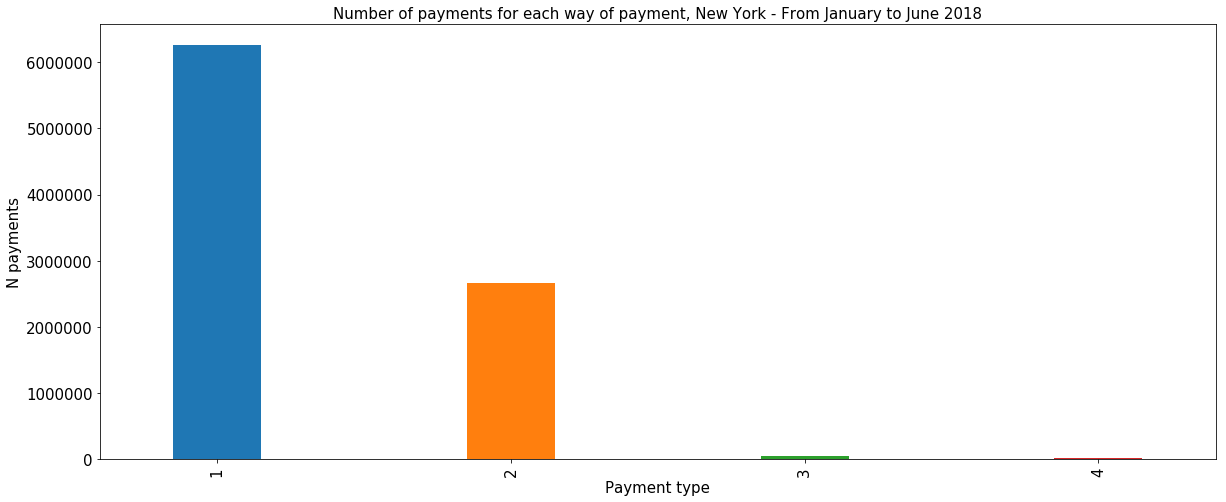

In [24]:
ax = pd.Series(result).plot(kind='bar',figsize=(20,8),legend=False, fontsize=15, width = 0.3)
ax.set_xlabel("Payment type",fontsize=15)
ax.set_ylabel("N payments",fontsize=15)
ax.set_title('Number of payments for each way of payment, New York - From January to June 2018', fontsize=15)

In [25]:
pd.Series(result)

1    6261021
2    2665560
3      47553
4      12867
dtype: int64

This histogram has on the x axis the payment type and on the y axis the number of payments in NYC. We can observe that the most used payment type is the credit card (about 6261021) . The second one is with cash.  

In [26]:
# We calculate the avarage number of payments in percentage for each borough and payment type in the whole period taken in analysis. 
# For each borough and payment type we sum the number of payments of every month and then we divide each sum to the number of the 
# months taken into consideration in our analysis (number of the months taken into consideration in our analysis = 6)

result = {}
for i in payment_borough_percentage_global: 
    for j in payment_borough_percentage_global[i]: 
        if j not in result: 
            result[j] = payment_borough_percentage_global[i][j]
        else: 
            result[j] += payment_borough_percentage_global[i][j]
            
for i in result: 
    result[i] = result[i]//6

We create an histogram that shows the number of payments, in percentage, for each borough and way of payment in NYC for the whole period in analysis.

Text(0.5,1,'Number of payments, in percentage, for each borough and way of payment - From January to June 2018')

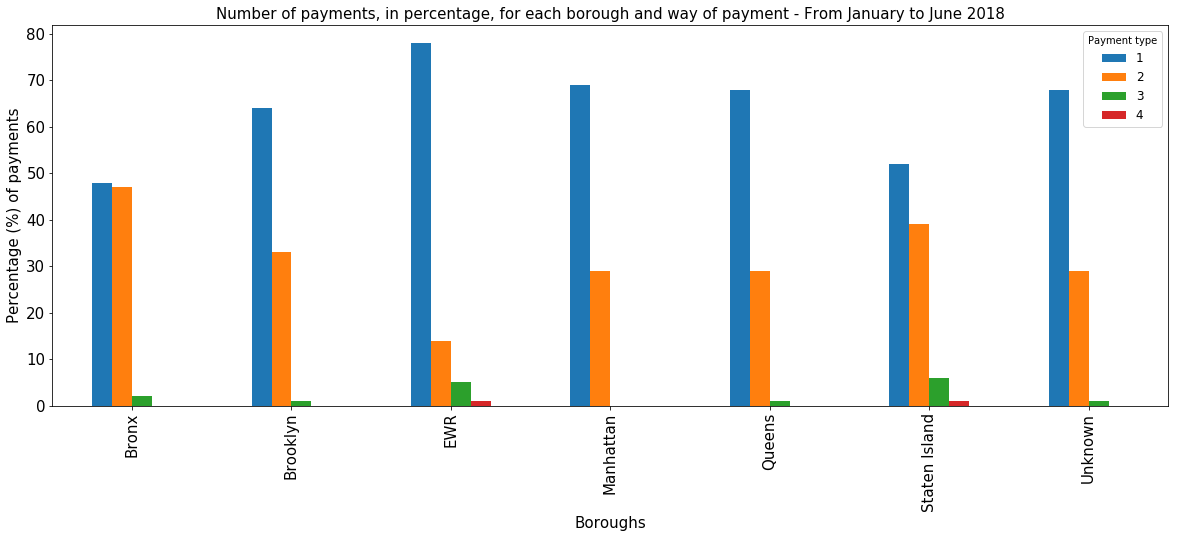

In [27]:
s = pd.Series(result)
ax = s.unstack().plot.bar(figsize =(20,7), fontsize = 15)
ax.set_xlabel("Boroughs",fontsize=15)
ax.set_ylabel("Percentage (%) of payments",fontsize=15)
ax.legend(fontsize=12, title = "Payment type")
ax.set_title("Number of payments, in percentage, for each borough and way of payment - From January to June 2018", fontsize=15)

This histogram has on the x axis the borough and on the y axis the percentage of payments in NYC. We can observe the most important way of payment are by credit card and cash for all borough except for Bronx where the payments by credit card (48%) and cash (47%) are almost the same. 

In [28]:
pd.Series(result)

Bronx          1    48.0
               2    47.0
               3     2.0
               4     0.0
Brooklyn       1    64.0
               2    33.0
               3     1.0
               4     0.0
EWR            1    78.0
               2    14.0
               3     5.0
               4     1.0
Manhattan      1    69.0
               2    29.0
               3     0.0
               4     0.0
Queens         1    68.0
               2    29.0
               3     1.0
               4     0.0
Staten Island  1    52.0
               2    39.0
               3     6.0
               4     1.0
Unknown        1    68.0
               2    29.0
               3     1.0
               4     0.0
dtype: float64

In [29]:
# We calculate the avarage number of payments for each borough and payment type in the whole period taken in analysis. 
# For each borough and payment type we sum the number of payments of every month and then we divide each sum to the number of the 
# months taken into consideration in our analysis (number of the months taken into consideration in our analysis = 6)

result = {}
for i in payment_borough_global: 
    for j in payment_borough_global[i]: 
        if j not in result: 
            result[j] = payment_borough_global[i][j]
        else: 
            result[j] += payment_borough_global[i][j]
            
for i in result: 
    result[i] = result[i]//6

temp = {}
for i in result:
    if i[0] not in temp:
        temp[i[0]] = {i[1] : result[i]}
    else:
        temp[i[0]].update({i[1]: result[i]})
        
frame = pd.DataFrame(temp)
frame

,Bronx,Brooklyn,EWR,Manhattan,Queens,Staten Island,Unknown
1,4631,73642,506,5697766,385186,72,99216
2,4357,38418,91,2413236,166769,53,42633
3,252,1464,36,37799,6215,8,1775
4,60,320,7,10602,1489,2,385


In [30]:
# Step 6: Run Chi-squared test to see whether the method of payment is correlated to the borough

chi2, p, dof, expected = chi2_contingency(frame)
chi2
print("Chi2:",chi2)
print("Pvalue:",p)

Chi2: 11957.876753995915
Pvalue: 0.0


Using the Chi-squared test we wont to see whether the method of payment is correlated to the borough. 
We make the following hypotheses: 

H_0 = {the method of payment is NOT correlated to the borough}

H_1 = {the method of payment is correlated to the borough} 

**N.B**: The p-value is printed as 0.0. This should be interpreted as p< 0.001, and not be taken as exactly 0

After our analysis we obtain a Chi-squared about 11958 with an associated p < 0.01.

The null hypothesis is rejected, since p < 0.001, and a conclusion is made that the method of payment is correlated to the borough. 


### [RQ5]  _Does a long distance correlate with the duration of the trip on average?_

The final goal of this request is to determinate if there is a dependence between distance and duration of the trip for NYC. 

Before accomplishing the task we need to pass through the following steps:

1. Obtain the data for the Taxis in NYC, starting from January 2018
2. Keep only the trips belonging to the month in question (ie. January 2018)
3. Merge between the data for the Taxis and the data for the taxi zone of NYC
4. Determinate a dependence between distance and duration of the trip
5. Repeat the previous steps for each month until June 2018

In [31]:
n = 1
while(n<7):
    csv_path = 'yellow_tripdata_2018-0'+str(n)+'.csv'
    
    # Step 1: Obtain the data for the Taxis in NYC, starting from January 2018
    
    # The first thing we do is to import the csv file containing the data of Taxis in NYC, in order to have a dataset with all
    # the informations. We import only the columns that interest us for our analysis. We parse the 'tpep_pickup_datetime' and
    # 'tpep_pickup_datetime' columns as dates.
    
    df_taxi= pd.read_csv(csv_path, usecols = [1,2,3,4,7,8,9,16], parse_dates = parse_dates, encoding = 'ISO-8859-1')
    
    # Step 2: Keep only the trips belonging to the month in question (ie. January 2018)
    
    # We clen the dataset. We drop the rows containig wrong values, as: different year from 2018, different month for the 
    # pickup datetime and dropoff datetime columns, same value in pickup_datetime and dropoff_datetime columns, trip distance
    # equal to 0. We decide to keep only the trips with maximum distance of 200 miles. 
    # We consider the trips at midnight as belonging to the day of pick up.
    
    df_taxi = df_taxi[df_taxi['tpep_pickup_datetime'].dt.year == 2018]
    df_taxi = df_taxi[df_taxi['tpep_pickup_datetime'].dt.month == n]
    df_taxi = df_taxi[df_taxi['tpep_dropoff_datetime'].dt.year == 2018]
    df_taxi = df_taxi[df_taxi['tpep_dropoff_datetime'].dt.month <= n+1]
    df_taxi = df_taxi[df_taxi['tpep_dropoff_datetime'] != df_taxi['tpep_pickup_datetime']]
    df_taxi = df_taxi[df_taxi['trip_distance'] != 0.00]
    df_taxi = df_taxi[df_taxi['trip_distance'] <= 200]
    
    # Step 3: Merge between the data for the Taxis and the data for the taxi zone of NYC
    
    # We perform a left join between the taxi dataset and the taxi zone dataset on 'PULocationID' and 'LocationId' columns, respectively 

    df_join = pd.merge(df_taxi,df_zone, how = 'left', left_on=['PULocationID'], right_on=['LocationID'])
    
    del df_taxi
    
    # Step 4: Determinate a dependence between distance and duration of the trip
    
    # The first thing to do is to create a new column in our dataset where we put the difference between dropoff datetime and 
    # pickup datetime that is the trip's duration. We drop the rows that have duration more than 1 day and negative duration.
    # We decide to keep only the trips with maximum duration of 4 hours. 
    
    df_join['duration'] = df_join['tpep_dropoff_datetime']-df_join['tpep_pickup_datetime']
    df_join = df_join[df_join['duration'].dt.days == 0]
    df_join = df_join[df_join['duration'].dt.seconds <= (3600*4)]

    # First we considered the trip's duration in seconds
    
    d_minutes = df_join['duration'].dt.seconds
    d_minutes = pd.DataFrame(d_minutes)
    
    # Then we commute the trip's duration from seconds to minutes
        
    d_minutes = d_minutes['duration'].apply(minutes)
    
    # We create a new Dataset with 2 columns: duration and trip distance.
    
    distance_duration_trip = pd.DataFrame(d_minutes)
    distance_duration_trip['trip_distance'] = df_join['trip_distance']
    
    # We save our results in a dataset containing only duration and distance of each trips
    
    df_global = df_global.append(distance_duration_trip)
        
    del df_join
    del d_minutes
    
    # Step 5: Repeat the previous steps for each month until June 2018
    
    n += 1

We create a plot that shows the dipendence between distance and duration of a trip in NYC for the whole period in analysis.

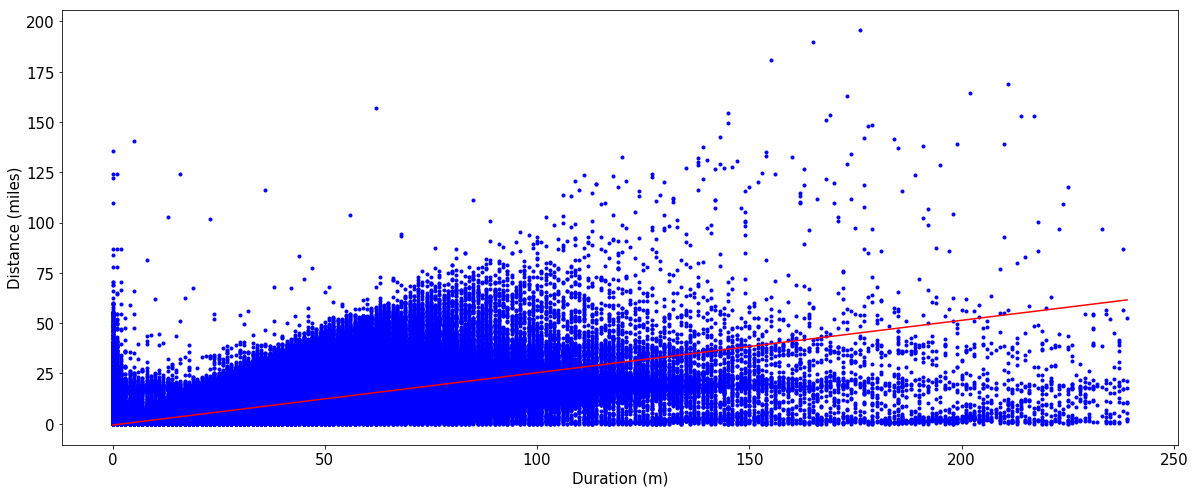

In [32]:
df_global['duration'] = pd.to_numeric(df_global['duration'])

x = df_global['duration'].tolist()
y = df_global['trip_distance'].tolist()
gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
mn=np.min(x)
mx=np.max(x)
x1=np.linspace(mn,mx)
y1=gradient*x1+intercept
fig, ax = plt.subplots(figsize=(20,8))
ax.tick_params(labelsize=15)
plt.xlabel('Duration (m)', fontsize=15)
plt.ylabel('Distance (miles)', fontsize=15)
plt.plot(x,y,'ob',markersize= 3)
plt.plot(x1,y1,'-r')
plt.show()

In [33]:
pearson = round(df_global['duration'].corr(df_global['trip_distance']),4)

In [34]:
print('Il coefficiente di Pearson è: ' + str(pearson))

Il coefficiente di Pearson è: 0.7983


A basic property of Pearson's rules is that its possible range is from -1 to 1. A correlation of -1 means a perfect negative linear relationship, a correlation of 0 means no linear relationship, and a correlation of 1 means a perfect linear relationship. Now, In our analysis we obtain that the Pearson Coefficient is equal to 0.7983 it's means that since it is close to 1, there is a positive linear relationship between trip's duration in minutes (X) and trip's distance (Y) in miles. We know that X and Y have a positive correlation when they grow up together and it's in part visible in our plot. 

## [CRQ2]: _Visualize Taxis movements!_ 

### Calculating count for each month

For calculating for the initial (Pick Up location) just change the name of column to "PULocationID"
and change the file name to save from "final" to "initial"

In [37]:
# processing each file individually
for i in range(1,7):
    file_name = 'yellow_tripdata_2018-0'+str(i)+'.csv'
    print(file_name)
    # read data from csv
    df = pd.read_csv(file_name)
    # process the data frame, count the number of start trips for each zone
    zone_counts = df['DOLocationID'].value_counts()
    zone_counts.sort_index(inplace=True)
    # convert zone_counts from series to DataFrame
    zone_count_df = pd.DataFrame(data = zone_counts, dtype = np.int64)
    zone_count_df.reset_index(level=0, inplace=True)
    zone_count_df.columns = ['DOLocationID', 'Count ']
    # write result to csv
    zone_count_df.to_csv('zone_count_yellow_tripdata_final_location_2018-0'+str(i)+'.csv')
    # Free the memory after finishing the data frame
    del [[df, zone_counts, zone_count_df]]
    df = None
    zone_counts = None
    zone_count_df = None

yellow_tripdata_2018-01.csv
yellow_tripdata_2018-02.csv
yellow_tripdata_2018-03.csv
yellow_tripdata_2018-04.csv
yellow_tripdata_2018-05.csv
yellow_tripdata_2018-06.csv


In [54]:
number_of_files = 6
# initial data frame for summation
##dict1 = {'PULocationID': list(range(1,266)), 'Count': 0.0}
##df_add = pd.DataFrame(dict1)
##df_add.index = df_add['PULocationID']
##df_add.info()


# Add first two data frames
df1 = pd.read_csv('zone_count_yellow_tripdata_final_location_2018-0'+str(1)+'.csv')
df2 = pd.read_csv('zone_count_yellow_tripdata_final_location_2018-0'+str(2)+'.csv')
# reset index of two data frames to use PULocationID as index
df1.index = df1['DOLocationID']
df2.index = df2['DOLocationID']
# delete previous index
del df1['Unnamed: 0']
del df2['Unnamed: 0']
# initial addition
df_add = df1.add(df2, fill_value = 0)

Change final to initial for calculating the initial location and "DOLocationID" to "PULocationID"

In [56]:
# read all other files
for i in range(3,number_of_files+1):
    df = pd.read_csv('zone_count_yellow_tripdata_final_location_2018-0'+str(i)+'.csv')
    #reset index
    df.index = df['DOLocationID']
    # delete previous index
    del df['Unnamed: 0']
    # perform addition to df1
    df_add = df_add.add(df, fill_value = 0)
    # clear after each step
    del df
    df = None

Change from DOLocationID to PULocationID for calculation of initial location

In [57]:
# reset PULocation values after the overall summation
df_add['DOLocationID'] = df_add.index

# delete number of trips for unknown locations
df_add.drop([264, 265], inplace = True)

Change name of file to save the percentage from final to initial

In [59]:
# rename columns 
df_add.columns = ['DOLocationID', 'Count']
# calculate percentage of trips per location
total_trips = np.sum(df_add['Count'])
#print("Total Count of Each zone", sum_count)
print('total sum of all trips = ', total_trips)
# create percentage column
df_add['percent'] = np.round((df_add['Count'] / total_trips) * 100, 5)

total sum of all trips =  53050027.0


Change name of file to save the percentage from final to initial

In [60]:
# write data to a file
df_add.to_csv('percentage of final location trips.csv')

# Map 

Always run this code when want to create and view a map

In [61]:
nyc_map_json = 'taxi_zones.json'
geo_json_data = json.load(open(nyc_map_json))

# use df_add or read the file percentage of trips.csv

nyc_map = folium.Map(location=[40.730610, -73.935242], tiles='cartodbpositron',zoom_start=10)

In [63]:
# this for initial location
import os
nyc_map.choropleth(geo_data=nyc_map_json, data=df_add,
             columns=['DOLocationID', 'percent'],
             key_on='feature.properties.LocationID',
             fill_color='YlGn', fill_opacity=0.4, line_opacity=0.2,
             legend_name='Rate of Pick Up (%)')
nyc_map.save(os.path.join('initial map.html'))

Run this code only when working with initial location

# Notes about the initial location trips

We can notice that Manhattan has the largest number of trips, also two airports, JFK and LaGuarida which is normal for airports as they are an active connection point

Run this cell of code only when you work for final location

In [64]:
# this for final location
nyc_map.choropleth(geo_data=nyc_map_json, data=df_add,
             columns=['DOLocationID', 'percent'],
             key_on='feature.properties.LocationID',
             fill_color='YlGn', fill_opacity=0.4, line_opacity=0.2,
             legend_name='Rate of left off (%)')
nyc_map.save(os.path.join('initial_map.html'))

# Notes About Left Off Location/zones

As can be seen from the map that Manhattan Area has the biggest number of trips among all NYC, also Bronx has one zone of largest number of trips.

## [CRQ1]: Does the fare for mile change across NY's borough?

For this question we analized only January.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

In [2]:
January = pd.read_csv("C://Users/Francesco/Desktop/Open data NYC Yellow cab/yellow_tripdata_2018-01.csv", usecols = [1,2,4,5,7,8,10,11,12,13,14,15,16], encoding = 'ISO-8859-1')

In [3]:
df_taxi_zone = pd.read_csv("C://Users/Francesco/Desktop/DATI PULITI/taxi _zone_lookup.csv", usecols = [0,1], encoding = 'ISO-8859-1')

In [4]:
#delte wrong years and months
January['new_date_start_column'] = pd.to_datetime(January['tpep_pickup_datetime']).dt.year#make a new column with only the year
year_start_null = January[January['new_date_start_column'] != 2018] #select all the rows with no 2018 year
January.drop(year_start_null.index, axis =0, inplace = True)#delete the rows

January['new_date_arrive_column'] = pd.to_datetime(January['tpep_dropoff_datetime']).dt.year#make a new column with only the year
year_arrive_null = January[January['new_date_arrive_column'] != 2018]#select all the rows with no 2018 year
January.drop(year_arrive_null.index, axis = 0, inplace = True)#delete rows

January['new_date_start_column_month'] = pd.to_datetime(January['tpep_pickup_datetime']).dt.month#make new column with only month
month_start_null = January[January['new_date_start_column_month'] != 1]#keep only wrong rows
January.drop(month_start_null.index, axis = 0, inplace = True)#delete rows
#delete the 3 columns above
January.drop(['new_date_start_column', 'new_date_arrive_column', 'new_date_start_column_month'], axis = 1, inplace = True)

In [5]:
# drop 0.00 distance
zero_values= January[January['trip_distance'] == 0.00]
January.drop(zero_values.index, axis = 0, inplace = True)

# debug "fare_amount" < 0.00
January.loc[January.fare_amount < 0, 'fare_amount'] = January['fare_amount'] * (-1)
#con "loc" mi seleziono solamente le righe che hanno valori negativi e dopo le sostituisco.
#lo faccio solo con il "fare_amount" perhé non mi interessa, per ora, andare a vedere anche il "total_amount"

# delete RatecodeID #99
#there're 4 values that have a wrong Ratecode, so we decided to exclude them from the analysis
code_99 = January[January.RatecodeID == 99]
January.drop(code_99.index, axis = 0, inplace = True)

# delete the inizial charge

if we wanna realy now the effective price per miles, first of all we need to delete the "The Initial Charge", that depens on the RatecodeID:

- RatecodeID 1 = 2.5 dollars
- RatecodeID 2 = 52 dollars
- RatecodeID 3 = 20 dollars
- RatecodeID 4 = 2.5 dollars
- RatecodeID 5 = the "fare_amount" is negotiated between the driver and the passengers
- RatecodeID 6 = the price is based on the number of peopole on the taxi

In [6]:
January.loc[January.RatecodeID == 1, 'fare_amount'] = January.fare_amount - 2.5 #Ratecode 1
January.loc[January.RatecodeID == 2, 'fare_amount'] = January.fare_amount - 52  #Ratecode 2
January.loc[January.RatecodeID == 3, 'fare_amount'] = January.fare_amount - 20  #Ratecode 3
January.loc[January.RatecodeID == 4, 'fare_amount'] = January.fare_amount - 2.5 #Ratecode 4

In [6]:
January.loc[January.RatecodeID == 1, 'fare_amount'] = January.fare_amount - 2.5 #Ratecode 1
January.loc[January.RatecodeID == 2, 'fare_amount'] = January.fare_amount - 52  #Ratecode 2
January.loc[January.RatecodeID == 3, 'fare_amount'] = January.fare_amount - 20  #Ratecode 3
January.loc[January.RatecodeID == 4, 'fare_amount'] = January.fare_amount - 2.5 #Ratecode 4

In [7]:
# "fare_amount" <= 0.00 delete
#we need to dalete those values because it doesn't make sence having fare_amount negative or equal to zero
zero_amount = January[January['fare_amount'] <= 0.00]
January.drop(zero_amount.index, axis = 0, inplace = True)

# I PART

# I.1) Compute price per mile per each trip


In [9]:
January['price_per_mile'] = January['fare_amount']/January['trip_distance']
#define a new serie colled 'price_per_value' where each value represents the price per mile
#in this case we are not considering the time spent in the traffic jam

# compute mean and std

In [10]:
January.price_per_mile.agg(['mean', 'std'])

mean     4.37615
std     44.71181
Name: price_per_mile, dtype: float64

In [12]:
'''As you can see there'are very strange values. It's impossible getting a mean = 4.37615 and a standard deviation = 44.71181
That's happened in particoular because there are weird values in trips with a Ratecode = 5, 
where the price per every race was accorded between the driver and the passenger. It could seem that eihter the driver asked for
an heavy price (as thief) or there was a mistake during the record upload. Whit the data in our hand, we can not know if the
drivers were thieves or the races were typed wrongly by the GPS technology.
Therefore, after a meticolus analysis we discovered that the other values belong to the records
with a "price_per_mile" greater than 20$ are unlikely, so we decided to keep them out form the compute (total amount = 6982).'''

strange_values = January[January.price_per_mile > 20.00]
January.drop(strange_values.index, axis = 0, inplace = True)

In [13]:
#compute the mean and the std again:
January.price_per_mile.agg(['mean', 'std'])

mean    3.963884
std     1.320340
Name: price_per_mile, dtype: float64

# I.2) Run the mean and std per each borough and plot
MERGE "January3" with "taxi_zone_lookup"

In [15]:
January_zone = pd.merge(January,df_taxi_zone, how = 'left', left_on=['PULocationID'], right_on=['LocationID'])

In [16]:
January_zone['Borough'] = January_zone['Borough'].astype('str')#we're gonna use str method
January_zone.groupby('Borough').price_per_mile.agg(['mean', 'std'])

,mean,std
Borough,,
Bronx,3.597890,1.334484
Brooklyn,3.480330,0.943658
EWR,5.201582,4.304133
Manhattan,4.016702,1.329137
Queens,3.024023,0.656405
Staten Island,3.228266,1.902298
Unknown,4.016883,1.378716


In [17]:
January_zone.groupby('Borough').price_per_mile.agg(['mean', 'std']).plot(kind = 'bar')

# I.3) T-test

- H0 : The races number depend on the price
- H1 : The races number don't depend on the price

In [18]:
Data1 = January_zone.groupby('Borough').price_per_mile.agg(['mean', 'std', 'var', 'count'])
Data1 = Data1.reset_index()#In this way I organized the df  whit an other index. 
#The Borough will no longer the index but just a column-label instead the new index will be the defoult index genereted automatically by pandas.
#In this way is  morehandable
Data1.drop([6], axis = 0, inplace = True)#I deleted the Unknown Borough just for simplify the compute.
Data1

,Borough,mean,std,var,count
0,Bronx,3.597890,1.334484,1.780848,6481
1,Brooklyn,3.480330,0.943658,0.890490,97497
2,EWR,5.201582,4.304133,18.525559,67
3,Manhattan,4.016702,1.329137,1.766606,7864314
4,Queens,3.024023,0.656405,0.430867,397390
5,Staten Island,3.228266,1.902298,3.618740,102


In [20]:
Data1_rolled1 = pd.DataFrame(pd.np.roll(Data1,1,axis = 0), columns = Data1.columns)
#I rolled the Data1 of just one position, 
#so I've a new df where the last Borough('State Island') is the first and the ex-first ('Bronx') is the second.
#(I said just one position, because I've to do this for other 3 times, so I'll have all the possible pairs of distribution of different Boroughs.)
Data1_joined1 = Data1.join(Data1_rolled1, rsuffix = ' (rolled = 1)')
#I join them so I can use le lambda function per each row, and get, as result, the P value per each couple of Borough.
Data1_joined1['P value (1)'] = Data1_joined1.apply(lambda x: stats.ttest_ind_from_stats(x['mean'],x['std'],x['count'], x['mean (rolled = 1)'],x['std (rolled = 1)'],x['count (rolled = 1)'])[1],axis=1)
#Use the lambda function to run the p-value per each row.

In [21]:
Data1_rolled2 = pd.DataFrame(pd.np.roll(Data1, 2, axis =0), columns = Data1.columns)
#I rolled the Data1 of two position, 
#so I've a new df where the second to last Borough('Queens') is the first and the ex-first ('Bronx') is the 3rd.
Data1_joined2= Data1.join(Data1_rolled2, rsuffix = ' (rolled = 2)')
#I join them so I can use le lambda function per each row and get, as result, the  P value per each couple of Borough.
Data1_joined2['P value (2)'] = Data1_joined2.apply(lambda x: stats.ttest_ind_from_stats(x['mean'],x['std'],x['count'], x['mean (rolled = 2)'],x['std (rolled = 2)'],x['count (rolled = 2)'])[1],axis = 1)
#Use the lambda function to run the p-value per each row.

In [22]:
Data1_rolled3 = pd.DataFrame(pd.np.roll(Data1, 3, axis = 0), columns = Data1.columns)
#I rolled the Data1 three one position, 
#so I've a new df where the 4th Borough('Manhattan') is the first and the ex-first ('Bronx') is the 4th.
Data1_joined3 = Data1.join(Data1_rolled3, rsuffix = ' (rolled = 3)')
#I join them so I can use le lambda function per each row and get, as result, the  P value per each couple of Borough.
Data1_joined3['P value (3)'] = Data1_joined3.apply(lambda x: stats.ttest_ind_from_stats(x['mean'], x['std'], x['count'], x['mean (rolled = 3)'], x['std (rolled = 3)'], x['count (rolled = 3)'])[1],axis = 1)
#Use the lambda function to run the p-value per each row.

In [23]:
Data1_rolled4 = pd.DataFrame(pd.np.roll(Data1, 4, axis = 0), columns = Data1.columns)
#I rolled the Data1 of four position, 
#so I've a new df where the 3rd Borough('EWR') is the first and the ex-first ('Bronx') is the 5th.
Data1_joined4 = Data1.join(Data1_rolled4, rsuffix = ' (rolled = 4)')
#I join them so I can use le lambda function per each row and get, as result, the  P value per each couple of Borough.
Data1_joined4['P value (4)'] = Data1_joined4.apply(lambda x: stats.ttest_ind_from_stats(x['mean'], x['std'], x['count'], x['mean (rolled = 4)'], x['std (rolled = 4)'], x['count (rolled = 4)'])[1],axis = 1)
#Use the lambda function to run the p-value per each row.

In [ ]:
Data1_joined1, Data1_joined2, Data1_joined3, Data1_joined4

# II PART

Compute the deltatime

In [25]:
#I'm gonna change the type of the values inside this two series from object to datetime
January_zone['tpep_pickup_datetime'] = pd.to_datetime(January_zone.tpep_pickup_datetime)
January_zone['tpep_dropoff_datetime'] = pd.to_datetime(January_zone.tpep_dropoff_datetime)

In [26]:
#and I'm gonna compute the time per each trip, and I'm gonna stick the output in a new serie.
January_zone['delta_time'] = (January_zone.tpep_dropoff_datetime - January_zone.tpep_pickup_datetime).astype('timedelta64[s]')
#express the output in seconds.

# II. 1) mean weigthed and std

In [27]:
#Get a serie where the values are the means of each Borough
Serie_mean_w = January_zone.groupby('Borough').apply(lambda x: np.average(x['price_per_mile'], weights = x['delta_time']))
#Get a serie where the values are the stds of each Borough
Serie_std_w = January_zone.groupby('Borough').apply(lambda x: np.sqrt(np.cov(x['price_per_mile'], aweights= x['delta_time'])))

In [28]:
#Convert the "Serie_mean_w" into dataframe 
Data_mean_w = Serie_mean_w.to_frame()
Data_mean_w= Data_mean_w.rename(columns= {0: 'weighted mean'})#change the name of the 0 label column to "weighted mean"
#Convert the "Serie_std_w" into dataframe
Data_std_w = Serie_std_w.to_frame()
Data_std_w = Data_std_w.rename (columns = {0: 'weighted std'})#change the name of the 0 label column to "std mean"

#Marge the two dataframes above
Data_weighted= pd.merge(Data_mean_w, Data_std_w, how='inner', right_index = True, left_index = True )

Data_weighted = Data_weighted.reset_index()#In this way I organized the df  whit an other index. 
#The Borough will no longer the index but just a column-label instead the new index will be the defoult index genereted automatically by pandas.
#In this way is  morehandable


#We're gonna marge the Data_weighted with the column Data1.count so I get number of reces per each Borough
Serie_count = Data1['count']#get a new serie from Data1 where the only column is the coulmn "count"
#convert the new serie into df:
Data_count= Serie_count.to_frame()
#Merge:
Data_weighted = pd.merge(Data_weighted, Data_count, how= 'inner', right_index = True, left_index = True)

In [29]:
Data_weighted

,Borough,weighted mean,weighted std,count
0,Bronx,3.611475,1.296860,6481
1,Brooklyn,3.497271,0.876594,97497
2,EWR,2.904677,1.799016,67
3,Manhattan,4.142551,1.405313,7864314
4,Queens,3.063355,0.603702,397390
5,Staten Island,3.621008,1.737542,102


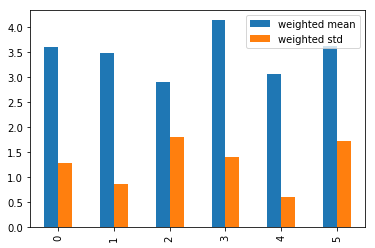

In [30]:
Data_weighted[['weighted mean', 'weighted std']].plot(kind = 'bar')

# II.3) T-Test

- H0 : The races number depend on the price
- H1 : The races number don't depend on the price

In [31]:
Data_weighted_1_rolled1 = pd.DataFrame(pd.np.roll(Data_weighted,1,axis = 0), columns = Data_weighted.columns)
#I rolled the Data1 of just one position, 
#so I've a new df where the last Borough('State Island') is the first and the ex-first ('Bronx') is the second.
#(I said just one position, because I've to do this for other 3 times, so I'll have all the possible pairs of distribution of different Boroughs.)

Data_weighted_1_joined1 = Data_weighted.join(Data_weighted_1_rolled1, rsuffix = ' (rolled = 1)')
#I join them so I can use le lambda function per each row, and get, as result, the P value per each couple of Borough.
Data_weighted_1_joined1['P value (1)'] = Data_weighted_1_joined1.apply(lambda x: stats.ttest_ind_from_stats(x['weighted mean'],x['weighted std'],x['count'], x['weighted mean (rolled = 1)'],x['weighted std (rolled = 1)'],x['count (rolled = 1)'])[1],axis=1)
#Use the lambda function to run the p-value per each row.

In [35]:
Data_weighted_1_rolled2 = pd.DataFrame(pd.np.roll(Data_weighted,2,axis = 0), columns = Data_weighted.columns)
#I rolled the Data1 of two position, 
#so I've a new df where the second to last Borough('Queens') is the first and the ex-first ('Bronx') is the 3rd.

Data_weighted_1_joined2 = Data_weighted.join(Data_weighted_1_rolled3, rsuffix = ' (rolled = 2)')
#I join them so I can use le lambda function per each row, and get, as result, the P value per each couple of Borough.


Data_weighted_1_joined2['P value (2)'] = Data_weighted_1_joined3.apply(lambda x: stats.ttest_ind_from_stats(x['weighted mean'],x['weighted std'],x['count'], x['weighted mean (rolled = 3)'],x['weighted std (rolled = 3)'],x['count (rolled = 3)'])[1],axis=1)
#Use the lambda function to run the p-value per each row.

In [36]:
Data_weighted_1_rolled3 = pd.DataFrame(pd.np.roll(Data_weighted,3,axis = 0), columns = Data_weighted.columns)
#I rolled the Data1 three one position, 
#so I've a new df where the 4th Borough('Manhattan') is the first and the ex-first ('Bronx') is the 4th.

Data_weighted_1_joined3 = Data_weighted.join(Data_weighted_1_rolled3, rsuffix = ' (rolled = 3)')
#I join them so I can use le lambda function per each row, and get, as result, the P value per each couple of Borough.


Data_weighted_1_joined3['P value (3)'] = Data_weighted_1_joined3.apply(lambda x: stats.ttest_ind_from_stats(x['weighted mean'],x['weighted std'],x['count'], x['weighted mean (rolled = 3)'],x['weighted std (rolled = 3)'],x['count (rolled = 3)'])[1],axis=1)
#Use the lambda function to run the p-value per each row.

In [37]:
Data_weighted_1_rolled4 = pd.DataFrame(pd.np.roll(Data_weighted,4,axis = 0), columns = Data_weighted.columns)
#I rolled the Data1 of four position, 
#so I've a new df where the 3rd Borough('EWR') is the first and the ex-first ('Bronx') is the 5th.

Data_weighted_1_joined4 = Data_weighted.join(Data_weighted_1_rolled4, rsuffix = ' (rolled = 4)')
#I join them so I can use le lambda function per each row, and get, as result, the P value per each couple of Borough.


Data_weighted_1_joined4['P value (4)'] = Data_weighted_1_joined4.apply(lambda x: stats.ttest_ind_from_stats(x['weighted mean'],x['weighted std'],x['count'], x['weighted mean (rolled = 4)'],x['weighted std (rolled = 4)'],x['count (rolled = 4)'])[1],axis=1)
#Use the lambda function to run the p-value per each row.

In [38]:
Data_weighted_1_joined1, Data_weighted_1_joined2, Data_weighted_1_joined3, Data_weighted_1_joined4

(         Borough  weighted mean  weighted std    count Borough (rolled = 1)  \
 0          Bronx       3.611475      1.296860     6481        Staten Island   
 1       Brooklyn       3.497271      0.876594    97497                Bronx   
 2            EWR       2.904677      1.799016       67             Brooklyn   
 3      Manhattan       4.142551      1.405313  7864314                  EWR   
 4         Queens       3.063355      0.603702   397390            Manhattan   
 5  Staten Island       3.621008      1.737542      102               Queens   
 
   weighted mean (rolled = 1) weighted std (rolled = 1) count (rolled = 1)  \
 0                    3.62101                   1.73754                102   
 1                    3.61147                   1.29686               6481   
 2                    3.49727                  0.876594              97497   
 3                    2.90468                   1.79902                 67   
 4                    4.14255                   